 # A simple test of using `optuna` for hyperparameter optimization

In [1]:
import time
from types import SimpleNamespace

import pydove as dv
from tqdm.notebook import tqdm

import torch
from cpcn import LinearCPCNetwork, load_mnist, train

import optuna
from optuna.trial import TrialState

 ## Defining the optimization

In [2]:
def optuna_reporter(trial: optuna.trial.Trial, ns: SimpleNamespace):
    trial.report(ns.epoch_val_loss, ns.epoch)

    # early pruning
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()


def create_cpcn(trial):
    n_hidden = trial.suggest_int("n_hidden", 1, 3)
    dims = [28 * 28]
    for i in range(n_hidden):
        n_units = trial.suggest_int(f"n_units_l{i}", 4, 128)
        dims.append(n_units)
    dims.append(10)

    z_lr = trial.suggest_float("z_lr", 1e-5, 1e-1, log=True)

    # set parameters to match a simple PCN network
    g_a = 0.5 * torch.ones(len(dims) - 2)
    g_a[-1] *= 2

    g_b = 0.5 * torch.ones(len(dims) - 2)
    g_b[0] *= 2

    net = LinearCPCNetwork(dims, z_lr=z_lr, z_it=50, g_a=g_a, g_b=g_b, c_m=0, l_s=g_b)

    return net


def objective(
    trial: optuna.trial.Trial, n_epochs: int, dataset: dict, device: torch.device
) -> float:
    net = create_cpcn(trial).to(device)

    optimizer_type = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    optimizer_class = getattr(torch.optim, optimizer_type)
    optimizer_kws = {"lr": lr}

    results = train(
        net,
        n_epochs,
        dataset["train"],
        dataset["validation"],
        optimizer=optimizer_class,
        optimizer_kwargs=optimizer_kws,
        reporter=lambda ns: optuna_reporter(trial, ns),
    )

    return results.validation.pc_loss[-1]

In [3]:
# minimizing PC loss
t0 = time.time()

device = torch.device("cpu")

n_epochs = 15
dataset = load_mnist(n_train=2000, n_validation=1000, batch_size=128)

study = optuna.create_study(direction="minimize")
study.optimize(
    lambda trial: objective(trial, n_epochs, dataset, device),
    n_trials=100,
    timeout=600,
    show_progress_bar=True,
)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

t1 = time.time()

[I 2022-04-19 18:10:00,494] A new study created in memory with name: no-name-8eb86d88-ab61-43ee-beb8-34533f70341c
/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-04-19 18:10:06,735] Trial 0 finished with value: 234.62002754211426 and parameters: {'n_hidden': 1, 'n_units_l0': 68, 'z_lr': 1.396572984186087e-05, 'optimizer': 'RMSprop', 'lr': 0.0002616989298218379}. Best is trial 0 with value: 234.62002754211426.
[I 2022-04-19 18:10:12,841] Trial 1 finished with value: 58.0662145614624 and parameters: {'n_hidden': 1, 'n_units_l0': 80, 'z_lr': 4.552045845430424e-05, 'optimizer': 'Adam', 'lr': 0.000898825179763433}. Best is trial 1 with value: 58.0662145614624.
[I 2022-04-19 18:10:26,615] Trial 2 finished with value: 1344148960.0 and parameters: {'n_hidden': 3, 'n_units_l0': 38, 'n_units_l1': 120, 'n_units_l2': 42, 'z_lr': 0.005224047887963055, 'optimizer': 'Adam', 'lr': 0.05517062145129547}. Best is trial 1 with value: 58.0662145614624.
[W 2022-04-19 18:10:34,611] Trial 3 failed, because the objective function returned nan.
[I 2022-04-19 18:10:43,363] Trial 4 finished with value: 1812.1015625 and parameters: {'n_hidden': 2, 'n_units_l0': 63,

/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-19 18:11:01,780] Trial 7 pruned. 
[I 2022-04-19 18:11:08,876] Trial 8 finished with value: 121.25624752044678 and parameters: {'n_hidden': 1, 'n_units_l0': 90, 'z_lr': 0.05695565558243151, 'optimizer': 'Adam', 'lr': 0.000524975811380883}. Best is trial 1 with value: 58.0662145614624.


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-19 18:11:09,348] Trial 9 pruned. 
[I 2022-04-19 18:11:10,299] Trial 10 pruned. 
[I 2022-04-19 18:11:13,687] Trial 11 finished with value: 495.53832244873047 and parameters: {'n_hidden': 1, 'n_units_l0': 5, 'z_lr': 0.00012652542879170944, 'optimizer': 'Adam', 'lr': 4.4308815579826314e-05}. Best is trial 1 with value: 58.0662145614624.
[I 2022-04-19 18:11:15,094] Trial 12 pruned. 
[I 2022-04-19 18:11:15,550] Trial 13 pruned. 
[I 2022-04-19 18:11:16,966] Trial 14 pruned. 
[I 2022-04-19 18:11:22,171] Trial 15 finished with value: 3678.4972229003906 and parameters: {'n_hidden': 1, 'n_units_l0': 46, 'z_lr': 0.0005090941651880445, 'optimizer': 'Adam', 'lr': 0.006665633203155863}. Best is trial 1 with value: 58.0662145614624.
[I 2022-04-19 18:11:22,878] Trial 16 pruned. 
[I 2022-04-19 18:11:23,463] Trial 17 pruned. 
[I 2022-04-19 18:11:24,153] Trial 18 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-19 18:11:24,420] Trial 19 pruned. 
[I 2022-04-19 18:11:32,001] Trial 20 finished with value: 77.82842636108398 and parameters: {'n_hidden': 1, 'n_units_l0': 111, 'z_lr': 0.009478371843289975, 'optimizer': 'RMSprop', 'lr': 0.00035958561849502065}. Best is trial 1 with value: 58.0662145614624.
[I 2022-04-19 18:11:32,707] Trial 21 pruned. 
[I 2022-04-19 18:11:38,903] Trial 22 finished with value: 108.68520259857178 and parameters: {'n_hidden': 1, 'n_units_l0': 82, 'z_lr': 0.002605670393026579, 'optimizer': 'RMSprop', 'lr': 0.0003477628120123441}. Best is trial 1 with value: 58.0662145614624.
[I 2022-04-19 18:11:47,213] Trial 23 finished with value: 77.54340934753418 and parameters: {'n_hidden': 1, 'n_units_l0': 125, 'z_lr': 0.002004449536006061, 'optimizer': 'RMSprop', 'lr': 0.00036378280721760834}. Best is trial 1 with value: 58.0662145614624.
[I 2022-04-19 18:11:47,832] Trial 24 pruned. 
[I 2022-04-19 18:11:55,870] Trial 25 finished with value: 45.328901290893555 and paramete

/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-19 18:12:28,985] Trial 36 pruned. 
[I 2022-04-19 18:12:29,912] Trial 37 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-19 18:12:30,880] Trial 38 pruned. 
[I 2022-04-19 18:12:31,245] Trial 39 pruned. 
[I 2022-04-19 18:12:32,029] Trial 40 pruned. 
[I 2022-04-19 18:12:32,421] Trial 41 pruned. 
[I 2022-04-19 18:12:40,239] Trial 42 finished with value: 52.78911113739014 and parameters: {'n_hidden': 1, 'n_units_l0': 123, 'z_lr': 0.001684841256441361, 'optimizer': 'RMSprop', 'lr': 0.0004733508834503891}. Best is trial 25 with value: 45.328901290893555.
[I 2022-04-19 18:12:47,435] Trial 43 finished with value: 57.99083995819092 and parameters: {'n_hidden': 1, 'n_units_l0': 97, 'z_lr': 0.0015518259212979535, 'optimizer': 'RMSprop', 'lr': 0.0005068170739433618}. Best is trial 25 with value: 45.328901290893555.
[I 2022-04-19 18:12:48,305] Trial 44 pruned. 
[I 2022-04-19 18:12:48,776] Trial 45 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-19 18:12:49,181] Trial 46 pruned. 
[I 2022-04-19 18:12:49,577] Trial 47 pruned. 
[I 2022-04-19 18:12:50,563] Trial 48 pruned. 
[I 2022-04-19 18:12:51,400] Trial 49 pruned. 
[I 2022-04-19 18:12:52,303] Trial 50 pruned. 
[I 2022-04-19 18:12:52,802] Trial 51 pruned. 
[I 2022-04-19 18:13:00,893] Trial 52 finished with value: 64.11477184295654 and parameters: {'n_hidden': 1, 'n_units_l0': 108, 'z_lr': 0.0016279436197696234, 'optimizer': 'RMSprop', 'lr': 0.0004799676966548949}. Best is trial 25 with value: 45.328901290893555.
[I 2022-04-19 18:13:08,432] Trial 53 finished with value: 52.328752517700195 and parameters: {'n_hidden': 1, 'n_units_l0': 107, 'z_lr': 0.0020466048265863077, 'optimizer': 'RMSprop', 'lr': 0.0005742634471321757}. Best is trial 25 with value: 45.328901290893555.
[I 2022-04-19 18:13:08,996] Trial 54 pruned. 
[I 2022-04-19 18:13:10,433] Trial 55 pruned. 
[I 2022-04-19 18:13:10,975] Trial 56 pruned. 
[I 2022-04-19 18:13:11,482] Trial 57 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-19 18:13:11,920] Trial 58 pruned. 
[I 2022-04-19 18:13:12,491] Trial 59 pruned. 
[I 2022-04-19 18:13:20,515] Trial 60 finished with value: 47.361722469329834 and parameters: {'n_hidden': 1, 'n_units_l0': 127, 'z_lr': 0.0024707817910588565, 'optimizer': 'RMSprop', 'lr': 0.0007348143960575052}. Best is trial 25 with value: 45.328901290893555.
[I 2022-04-19 18:13:28,332] Trial 61 finished with value: 46.39998006820679 and parameters: {'n_hidden': 1, 'n_units_l0': 128, 'z_lr': 0.0025758638131069076, 'optimizer': 'RMSprop', 'lr': 0.0006422926472027571}. Best is trial 25 with value: 45.328901290893555.
[I 2022-04-19 18:13:36,610] Trial 62 finished with value: 48.26640701293945 and parameters: {'n_hidden': 1, 'n_units_l0': 126, 'z_lr': 0.002136753415751433, 'optimizer': 'RMSprop', 'lr': 0.0006653649359911815}. Best is trial 25 with value: 45.328901290893555.
[I 2022-04-19 18:13:44,660] Trial 63 finished with value: 49.40270709991455 and parameters: {'n_hidden': 1, 'n_units_l0': 128

/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-19 18:14:14,102] Trial 80 pruned. 
[I 2022-04-19 18:14:14,602] Trial 81 pruned. 
[I 2022-04-19 18:14:22,612] Trial 82 finished with value: 54.93153476715088 and parameters: {'n_hidden': 1, 'n_units_l0': 125, 'z_lr': 0.006089703228132665, 'optimizer': 'RMSprop', 'lr': 0.0010612140002450718}. Best is trial 69 with value: 40.018378257751465.
[I 2022-04-19 18:14:28,617] Trial 83 pruned. 
[I 2022-04-19 18:14:29,647] Trial 84 pruned. 
[I 2022-04-19 18:14:30,180] Trial 85 pruned. 
[I 2022-04-19 18:14:31,369] Trial 86 pruned. 
[I 2022-04-19 18:14:32,034] Trial 87 pruned. 
[I 2022-04-19 18:14:33,203] Trial 88 pruned. 
[I 2022-04-19 18:14:34,229] Trial 89 pruned. 
[I 2022-04-19 18:14:34,806] Trial 90 pruned. 
[I 2022-04-19 18:14:35,353] Trial 91 pruned. 
[I 2022-04-19 18:14:35,694] Trial 92 pruned. 
[I 2022-04-19 18:14:37,676] Trial 93 pruned. 
[I 2022-04-19 18:14:45,701] Trial 94 finished with value: 44.17405891418457 and parameters: {'n_hidden': 1, 'n_units_l0': 121, 'z_lr': 0.00313

/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-19 18:15:02,991] Trial 98 pruned. 
[I 2022-04-19 18:15:03,549] Trial 99 pruned. 


In [4]:
print(
    f"{len(study.trials)} trials in {t1 - t0:.1f} seconds: "
    f"{len(complete_trials)} complete, {len(pruned_trials)} pruned."
)

trial = study.best_trial
print(f"best pc_loss: {trial.value}, for params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

100 trials in 303.2 seconds: 30 complete, 69 pruned.
best pc_loss: 40.018378257751465, for params:
    n_hidden: 1
    n_units_l0: 112
    z_lr: 0.004946861968902642
    optimizer: RMSprop
    lr: 0.0005594766912852229


<ipython-input-6-83c13c1a414d>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

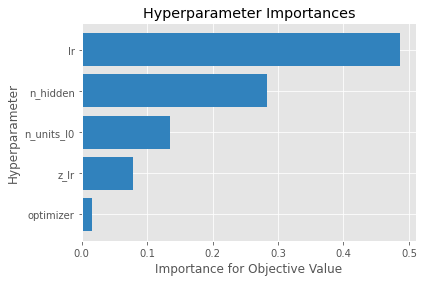

In [6]:
optuna.visualization.matplotlib.plot_param_importances(study)